In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/cs5228-2021s1/sample_output.csv
/kaggle/input/cs5228-2021s1/dataset_info.docx
/kaggle/input/cs5228-2021s1/Xtest.csv
/kaggle/input/cs5228-2021s1/Ytrain.csv
/kaggle/input/cs5228-2021s1/Xtrain.csv


In [2]:
# data manipulation
import pandas as pd
import numpy as np

# visualization
import seaborn as sb
import matplotlib.pyplot as plt
import time
%matplotlib inline

# model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# # classifiers
# from sklearn.naive_bayes import GaussianNB # naive bayes
# from sklearn.neighbors import KNeighborsClassifier # KNN
# from sklearn.linear_model import LogisticRegression # logistic regression
# from sklearn.tree import DecisionTreeClassifier # decision Tree
# from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load Data
xtrain = pd.read_csv("/kaggle/input/cs5228-2021s1/Xtrain.csv")
ytrain = pd.read_csv("/kaggle/input/cs5228-2021s1/Ytrain.csv")
xtest = pd.read_csv('/kaggle/input/cs5228-2021s1/Xtest.csv')
print(ytrain.dtypes)
print(xtrain.shape)
print(xtest.shape)
xall = xtrain.append(xtest, ignore_index=True)
print(xall.shape)
print("dtype of each column")
# print(y_train.dtypes)
print(xall.dtypes)

Id           int64
ChargeOff    int64
dtype: object
(50000, 24)
(100000, 24)
(150000, 24)
dtype of each column
Id                     int64
Name                  object
City                  object
State                 object
Zip                    int64
Bank                  object
BankState             object
NAICS                  int64
ApprovalDate          object
ApprovalFY            object
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
DisbursementDate      object
DisbursementGross     object
BalanceGross          object
GrAppv                object
SBA_Appv              object
dtype: object


In [4]:
fields = list(xall.columns.values.tolist()) 
# print(fields)
count = 0
for i in fields:
    emp = xall[(xall[i].isnull())].index
    print(i,len(emp))
    count += len(emp)

print("Deleted {} rows".format(count))

Id 0
Name 2
City 1
State 4
Zip 0
Bank 187
BankState 189
NAICS 0
ApprovalDate 0
ApprovalFY 0
Term 0
NoEmp 0
NewExist 21
CreateJob 0
RetainedJob 0
FranchiseCode 0
UrbanRural 0
RevLineCr 494
LowDoc 635
DisbursementDate 371
DisbursementGross 0
BalanceGross 0
GrAppv 0
SBA_Appv 0
Deleted 1904 rows


In [5]:
def convertFY(var):
    if isinstance(var, str):
        return var.replace('A', '')
    return var

def convertFrCode(var):
    if var>2: return 1
    else: return 0

def convertCurrency(var):
    str(var)
    return var.replace('$', '').replace(',', '')

def convertDate(var):
    date = time.strptime(var,'%d-%b-%y')
    return 365*date.tm_year + date.tm_yday

def convertNAICS(var):
    var = str(var)
    return int(var[:2])

def convertCurrency(var):
    var = str(var)
    return var.replace('$', '').replace(',', '')

def convertDate(var):
    str(var)
    date = time.strptime(var,'%d-%b-%y')
    return 365*date.tm_year + date.tm_yday

def checkname(var):
    if isinstance(var, str):
        if (var.find('LLC'or 'L.L.C' or 'L L C') != -1): 
            var = 'LLC'
        elif (var.find('INC'or 'Inc' or 'CORPORATION' or 'PLC' or 'P.C' or 'PC') != -1):
            var = 'INC'
        elif (var.find('LLP'or 'L.L.P') != -1):
            var = 'LLP'
        else:
            var = 'Company'
    return var

In [6]:
xall = xall.fillna({'State':'_NA_', 'BankState':'_NA_', 'NewExist':1., 'RevLineCr':'N', 'LowDoc':'N'})

xall['NAICS'] = xall['NAICS'].apply(convertNAICS)
# print(xall['NAICS'][:5])
print(xall['NAICS'].value_counts())

0     26745
44    15741
81    12747
23    12452
72    12300
54    11820
42     8389
45     7999
62     7806
56     6215
33     5820
48     4044
32     2921
53     2829
71     2571
51     2230
31     2087
52     1972
61     1209
11     1204
49      438
21      266
22      117
55       41
92       37
Name: NAICS, dtype: int64


In [7]:
xall['ApprovalFY'] = xall['ApprovalFY'].apply(convertFY).astype('int64')
cleanup_nums = {
    'RevLineCr':{'T':'Y', '0':'N', '1':'Y', 'Q':'Y', 'R':'Y', '2':'Y'},
    'LowDoc':{'S':'Y', '0':'N', 'C':'Y', 'A':'Y', 'R':'Y'},
    'NewExist':{0.:1.}, 
#     'NAICS':{0:'NA','21':'Mining',11:'Agriculture',55:'Management',62:'Health',22:'Utilities',92:'Administration',
#             54:'Science',42:'Wholesale',31:'Manufacturing',32:'Manufacturing',33:'Manufacturing',81:'Others',
#             71:'Arts',72:'Food',44:'Retail',45:'Retail',23:'Construction',56:'Service',61:'Education',
#             51:'Information',48:'Transport',49:'Transport',52:'Finance',53:'RE'}
}
xall.replace(cleanup_nums, inplace=True)

In [8]:
xall['NewExist'] = xall['NewExist'].astype('int64')
xall['DisbursementGross'] = xall['DisbursementGross'].apply(convertCurrency)
xall['DisbursementGross'] = xall['DisbursementGross'].astype('float64')
xall['GrAppv'] = xall['GrAppv'].apply(convertCurrency)
xall['GrAppv'] = xall['GrAppv'].astype('float64')
xall['SBA_Appv'] = xall['SBA_Appv'].apply(convertCurrency)
xall['SBA_Appv'] = xall['SBA_Appv'].astype('float64')

In [9]:
xall['ApprovalDate'] = pd.to_datetime(xall['ApprovalDate'])
xall['DisbursementDate'] = pd.to_datetime(xall['DisbursementDate'])
xall['DTD'] = (xall['DisbursementDate'] - xall['ApprovalDate']).dt.days
dtdmean = xall['DTD'].mean()
xall['DTD'] = xall['DTD'].fillna(dtdmean)
xall['DTD'] = xall['DTD'].astype('int64')
print(xall['DTD'][:5])

xall['FranchiseCode'] = xall['FranchiseCode'].apply(convertFrCode)

xall['Name_type'] = xall['Name'].apply(checkname)
xall['Name_type'] = xall['Name_type'].fillna('Company')

xall['appv_ratio'] = xall['SBA_Appv'] / xall['GrAppv']

xall['Statecomp'] = np.where(xall['State'] == xall['BankState'],1,0)


0    15
1     2
2    33
3    51
4    53
Name: DTD, dtype: int64


In [10]:
indcode_to_indrisk = {11: 'Low', 21: 'Low', 55: 'Low', 62: 'Low', 0: 'Low',
                        22: 'Moderate', 23: 'Moderate', 31: 'Moderate', 32: 'Moderate', 33: 'Moderate',
                        42: 'Moderate', 44: 'Moderate', 45: 'Moderate', 48: 'Moderate', 49: 'Moderate',                        
                        51: 'Moderate', 54: 'Moderate', 56: 'Moderate', 71: 'Moderate', 72: 'Moderate', 81: 'Moderate',
                        52: 'Moderate', 53: 'Moderate', 61: 'Moderate', 92: 'Moderate'}
xall['IndRisk'] = xall['NAICS'].map(indcode_to_indrisk)
naics = {0:'NA','21':'Mining',11:'Agriculture',55:'Management',62:'Health',22:'Utilities',92:'Administration',
            54:'Science',42:'Wholesale',31:'Manufacturing',32:'Manufacturing',33:'Manufacturing',81:'Others',
            71:'Arts',72:'Food',44:'Retail',45:'Retail',23:'Construction',56:'Service',61:'Education',
            51:'Information',48:'Transport',49:'Transport',52:'Finance',53:'RE'}
xall['NAICS'] = xall['NAICS'].map(naics)
xall['Job'] = xall['CreateJob'] - xall['RetainedJob']

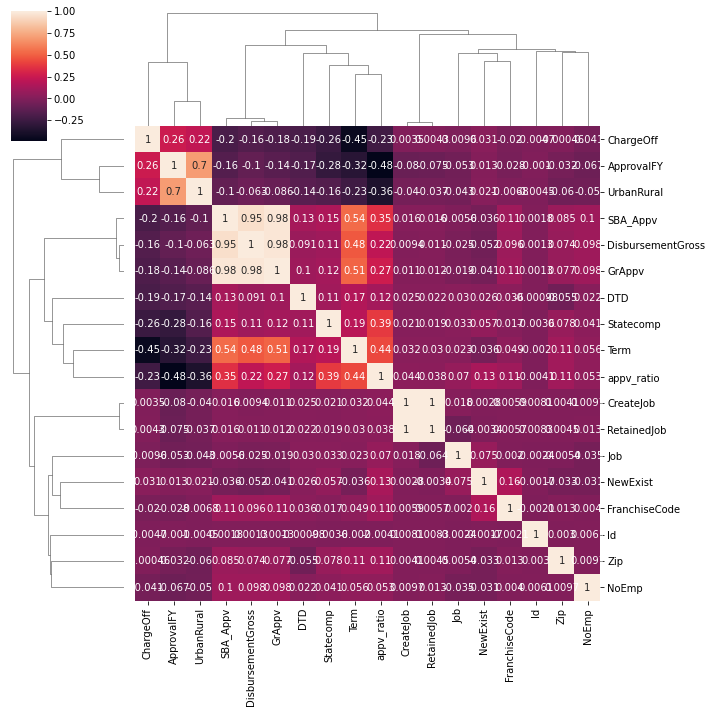

In [11]:
cv = xall.loc[0:49999]
cv['ChargeOff'] = ytrain['ChargeOff']
# cv['Job'] = cv['CreateJob'] - cv['RetainedJob']
sb.clustermap(cv.corr(), annot = True, figsize=(10,10))

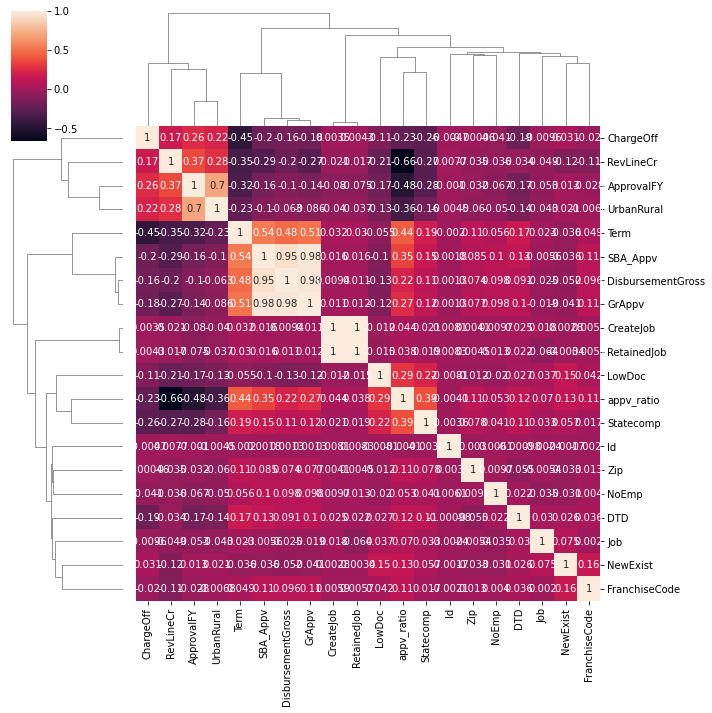

In [12]:
# cv['Job'] = cv['CreateJob'] - cv['RetainedJob']
cv['RevLineCr'] = np.where(cv['RevLineCr'] == 'Y',1,0)
cv['LowDoc'] = np.where(cv['LowDoc'] == 'Y',1,0)
# cv.drop(['NAICS'],1)
sb.clustermap(cv.corr(), annot = True, figsize=(10,10))

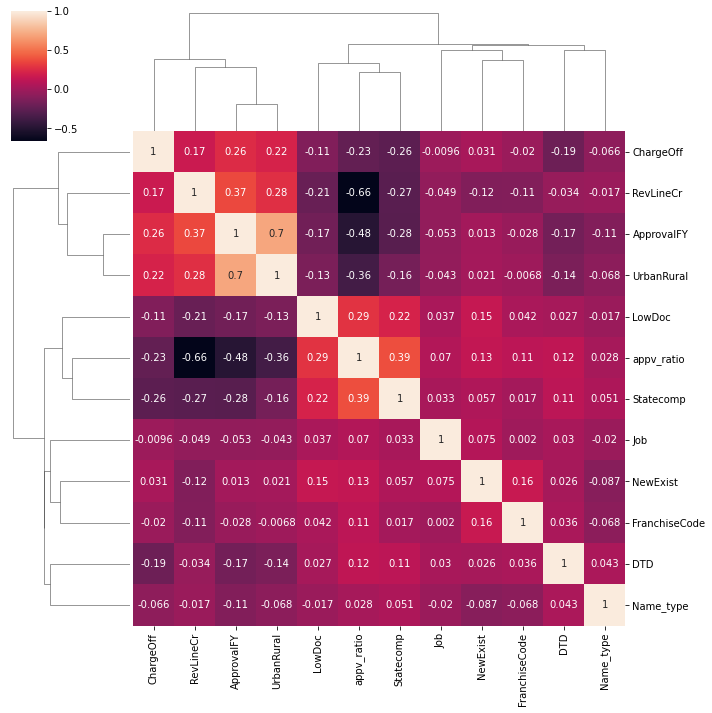

In [13]:
cv = cv.drop(['Name', 'BankState','City', 'Zip', 'Bank', 'BalanceGross','NoEmp', 
                  'CreateJob', 'RetainedJob','ApprovalDate', 'DisbursementDate','GrAppv','SBA_Appv','Id','Term','DisbursementGross'], 1)
cv['Name_type'] = cv['Name_type'].map({'Company':0, 'LLC':1, 'LLP':2, 'INC':3})
# print(xall.dtypes)
sb.clustermap(cv.corr(), annot = True, figsize=(10,10))

In [14]:
xall['NAICS'] = xall['NAICS'].astype('category')
xall['IndRisk'] = xall['IndRisk'].astype('category')
xall['NewExist'] = xall['NewExist'].astype('category')
xall['FranchiseCode'] = xall['FranchiseCode'].astype('category')
xall['UrbanRural'] = xall['UrbanRural'].astype('category')
xall['RevLineCr'] = xall['RevLineCr'].astype('category')
xall['LowDoc'] = xall['LowDoc'].astype('category')
xall['ApprovalFY'] = xall['ApprovalFY'].astype('category')
xall['Name_type'] = xall['Name_type'].astype('category')
xall['Statecomp'] = xall['Statecomp'].astype('category')
xall['State'] = xall['State'].astype('category')

In [15]:
xall_f = xall.drop(['Name', 'BankState','City', 'Zip', 'Bank', 'BalanceGross','NoEmp', 
                  'CreateJob', 'RetainedJob','ApprovalDate', 'DisbursementDate','GrAppv',
                  'SBA_Appv','Id'], 1)
print(xall_f.dtypes)

State                category
NAICS                category
ApprovalFY           category
Term                    int64
NewExist             category
FranchiseCode        category
UrbanRural           category
RevLineCr            category
LowDoc               category
DisbursementGross     float64
DTD                     int64
Name_type            category
appv_ratio            float64
Statecomp            category
IndRisk              category
Job                     int64
dtype: object


In [16]:
xall1h = pd.get_dummies(xall_f, columns=[
    'State', 'ApprovalFY', 'NewExist', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'Name_type',
    'NAICS', 'IndRisk', 'Statecomp'])
print(xall1h.shape)

(150000, 143)


In [17]:
xtrain_ = xall1h.loc[0:49999]
xtest_ = xall1h.loc[50000:]
ytrain_ = ytrain['ChargeOff']
print(xtrain_.shape)
print(xtest_.shape)
print(ytrain_.shape)

(50000, 143)
(100000, 143)
(50000,)


In [18]:
x_train, x_val, y_train, y_val = train_test_split(xtrain_, ytrain_, test_size = 0.05, random_state=0)
print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)

(47500, 143) (2500, 143)
(47500,) (2500,)


GB           
-default: 88.4       
-n-estimators = 400 : 91.52         
-n_estimators=400, max_depth=5: 92.96        
-n_estimators=400, max_depth=5, min_samples_split=3: 93.04            

XGB        
-default: 93.04

In [19]:
GBM = GradientBoostingClassifier() 
GBM.fit(x_train,y_train)
y_pred = GBM.predict(x_val)
acc = round(accuracy_score(y_val, y_pred) * 100, 2)
f1 = round(f1_score(y_val, y_pred, average='weighted') * 100, 2)
print(acc,f1)

88.72 88.72


In [20]:
params = { 'n_estimators':[200,400,600,800]}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,
                min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10),
                        param_grid = params, scoring='accuracy',n_jobs=4,iid=False, cv=5)

# tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt'), 
#             param_grid = params, scoring='accuracy',n_jobs=4,iid=False, cv=10)

gsearch1.fit(x_train,y_train)
print("Best performing Learning rate and number of trees is:")
print(gsearch1.best_params_, gsearch1.best_score_)

Best performing Learning rate and number of trees is:
{'n_estimators': 800} 0.9181052631578949


In [21]:
params = { 'n_estimators':[40, 50,60,70,80,90,100,150]}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,
                min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10),
                        param_grid = params, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

# tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt'), 
#             param_grid = params, scoring='accuracy',n_jobs=4,iid=False, cv=10)

gsearch1.fit(x_train,y_train)
print("Best performing Learning rate and number of trees is:")
print(gsearch1.best_params_, gsearch1.best_score_)

Best performing Learning rate and number of trees is:
{'n_estimators': 150} 0.957589050646116


In [22]:
GBM = GradientBoostingClassifier(n_estimators=500, learning_rate=0.2) 
GBM.fit(x_train,y_train)
y_pred = GBM.predict(x_val)
acc = round(accuracy_score(y_val, y_pred) * 100, 2)
f1 = round(f1_score(y_val, y_pred, average='weighted') * 100, 2)
print(acc,f1)

92.68 92.68


In [23]:
# max-depth tuning
params1 = {'max_depth':[1,2,3,4,5]}
tuning1 = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.2, n_estimators=500, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt'), 
            param_grid = params1, scoring='accuracy',n_jobs=4,iid=False, cv=10)
tuning1.fit(x_train,y_train)
print("Best performing maximum depth of trees is:")
print(tuning1.best_params_, tuning1.best_score_)

Best performing maximum depth of trees is:
{'max_depth': 5} 0.9094315789473685


In [24]:
GBM = GradientBoostingClassifier(learning_rate=0.2, n_estimators=500, max_depth=5) 
GBM.fit(x_train,y_train)
y_pred = GBM.predict(x_val)
acc = round(accuracy_score(y_val, y_pred) * 100, 2)
f1 = round(f1_score(y_val, y_pred, average='weighted') * 100, 2)
print(acc,f1)

93.12 93.12


In [25]:
y_test_pred = GBM.predict(xtest_)
print(y_test_pred.shape)
out = pd.Series(y_test_pred, name='ChargeOff')
out.to_csv('submission.csv', index_label='Id')

(100000,)


In [26]:
# min_samples_split tuning
params2 = {'min_samples_split':[2,5,10,15,20]}
tuning2 = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.2, n_estimators=500, max_depth=5, min_samples_leaf=1, subsample=1,max_features='sqrt'), 
            param_grid = params2, scoring='accuracy',n_jobs=4,iid=False, cv=10)
tuning2.fit(x_train,y_train)
print("Best performing minimum no of samples for split is:")
print(tuning2.best_params_, tuning2.best_score_)

Best performing minimum no of samples for split is:
{'min_samples_split': 2} 0.9104421052631579


In [27]:
GBM1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000, max_depth=7,min_samples_split=5) 
GBM1.fit(x_train,y_train)
y_pred = GBM1.predict(x_val)
acc = round(accuracy_score(y_val, y_pred) * 100, 2)
f1 = round(f1_score(y_val, y_pred, average='weighted') * 100, 2)
print(acc,f1)

93.0 93.0


In [28]:
y_test_pred = GBM1.predict(xtest_)
print(y_test_pred.shape)
out = pd.Series(y_test_pred, name='ChargeOff')
out.to_csv('submission1.csv', index_label='Id')

(100000,)


In [29]:
GBM2 = GradientBoostingClassifier(learning_rate=0.2, n_estimators=600,min_samples_leaf=40, 
                                  max_depth=8,subsample=0.8, min_samples_split=1200,max_features='sqrt') 
GBM2.fit(x_train,y_train)
y_pred = GBM2.predict(x_val)
acc = round(accuracy_score(y_val, y_pred) * 100, 2)
f1 = round(f1_score(y_val, y_pred, average='weighted') * 100, 2)
print(acc,f1)

92.12 92.12


In [30]:
from xgboost import XGBClassifier

XGB = XGBClassifier(n_estimators=1000, learning_rate=0.05)
XGB.fit(x_train, y_train,early_stopping_rounds=5, 
             eval_set=[(x_val, y_val)], verbose=True)

# y_pred = GBM1.predict(x_val)
# acc = round(accuracy_score(y_val, y_pred) * 100, 2)
# f1 = round(f1_score(y_val, y_pred, average='weighted') * 100, 2)
# print(acc,f1)

[0]	validation_0-error:0.11960
Will train until validation_0-error hasn't improved in 5 rounds.
[1]	validation_0-error:0.11840
[2]	validation_0-error:0.11920
[3]	validation_0-error:0.11880
[4]	validation_0-error:0.12320
[5]	validation_0-error:0.11840
[6]	validation_0-error:0.12320
Stopping. Best iteration:
[1]	validation_0-error:0.11840



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
XGB1 = XGBClassifier(n_estimators=200, learning_rate=0.05)
eval_set = [(x_train, y_train), (x_val, y_val)]
eval_metric = ["auc","error"]
%time XGB1.fit(x_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.93677	validation_0-error:0.12223	validation_1-auc:0.93959	validation_1-error:0.11960
[1]	validation_0-auc:0.93792	validation_0-error:0.12187	validation_1-auc:0.94099	validation_1-error:0.11840
[2]	validation_0-auc:0.93869	validation_0-error:0.12145	validation_1-auc:0.94196	validation_1-error:0.11920
[3]	validation_0-auc:0.94091	validation_0-error:0.11996	validation_1-auc:0.94392	validation_1-error:0.11880
[4]	validation_0-auc:0.94000	validation_0-error:0.12253	validation_1-auc:0.94347	validation_1-error:0.12320
[5]	validation_0-auc:0.94340	validation_0-error:0.12002	validation_1-auc:0.94622	validation_1-error:0.11840
[6]	validation_0-auc:0.94400	validation_0-error:0.12154	validation_1-auc:0.94595	validation_1-error:0.12320
[7]	validation_0-auc:0.94500	validation_0-error:0.12187	validation_1-auc:0.94757	validation_1-error:0.12200
[8]	validation_0-auc:0.94507	validation_0-error:0.12240	validation_1-auc:0.94773	validation_1-error:0.12160
[9]	validation_0-auc:0.94710

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

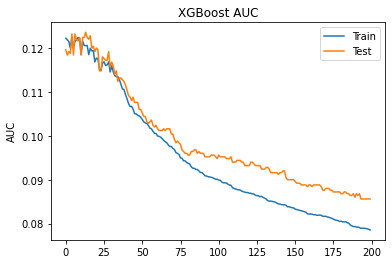

In [32]:
results = XGB1.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

In [33]:
XGBtry = XGBClassifier(random_state=999, learning_rate=0.075, n_estimators=700)
XGBtry.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.075, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=700, n_jobs=0, num_parallel_tree=1, random_state=999,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
y_pred = XGBtry.predict(x_val)
acc = round(accuracy_score(y_val, y_pred) * 100, 2)
f1 = round(f1_score(y_val, y_pred, average='weighted') * 100, 2)
print(acc,f1)

93.16 93.16


In [35]:
y_test_pred = XGB.predict(xtest_)
print(y_test_pred.shape)
out = pd.Series(y_test_pred, name='ChargeOff')
out.to_csv('submission3.csv', index_label='Id')

(100000,)
